In [18]:
!pip install -q panns_inference speechbrain noisereduce

In [19]:
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler
import noisereduce as nr # For noise reduction

# --- Model Imports ---
# PANNs
from panns_inference import AudioTagging


In [20]:
# --- Constants and Parameters ---
PANNS_SR = 32000 # Target sample rate for PANNs and processing

# MEL Spectrogram Parameters
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# Augmentation Blending factor
ALPHA = 0.5

# Noise Reduction Parameters (tune these if needed)
# Higher prop_decrease reduces more noise but might affect desired sounds
PROP_DECREASE = 0.9
# Use stationary=False if background noise changes over time
STATIONARY_NOISE = False

# --- Audio File Path ---
audio_file_path = "/content/iNat65519.ogg" # Ensure this file exists
output_denoised_audio_path = "/content/iNat65519_nr_denoised.wav" # Filename for noise-reduced audio


In [21]:
# --- Function Definitions ---
# (Using the robust versions from previous steps)
def get_panns_embedding(waveform_np, model, device, target_sr):
    """Extracts PANNs embedding from NumPy array."""
    if waveform_np is None: return None
    try:
        audio_tensor = torch.from_numpy(waveform_np).unsqueeze(0).to(device)
        with torch.no_grad(): _, embedding_output = model.inference(audio_tensor)
        if isinstance(embedding_output, torch.Tensor): embedding_numpy = embedding_output.squeeze(0).cpu().numpy()
        elif isinstance(embedding_output, np.ndarray):
            if embedding_output.ndim > 1 and embedding_output.shape[0] == 1: embedding_numpy = embedding_output.squeeze(0)
            else: embedding_numpy = embedding_output
        else: print(f"Error: Unexpected embedding type: {type(embedding_output)}"); return None
        print(f"Generated PANNs embedding with shape: {embedding_numpy.shape}")
        return embedding_numpy
    except Exception as e: print(f"Error during PANNs inference: {e}"); return None

def calculate_mel_spectrogram(waveform_np, sr, n_fft, hop_length, n_mels):
    """Calculates the log-MEL spectrogram from NumPy array."""
    if waveform_np is None: return None
    try:
        mel_spec = librosa.feature.melspectrogram(y=waveform_np, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        # print(f"Calculated MEL spectrogram ({sr}Hz) with shape: {log_mel_spec.shape}") # Less verbose
        return log_mel_spec
    except Exception as e: print(f"Error calculating MEL spectrogram: {e}"); return None

def create_augmented_mel(log_mel_spec, panns_embedding, n_mels, alpha=1.0):
    """Creates augmented MEL by adding projected, normalized embedding features."""
    if log_mel_spec is None or panns_embedding is None: return None
    embed_dim = panns_embedding.shape[0]; time_steps = log_mel_spec.shape[1]
    if embed_dim == n_mels: proj_embedding = panns_embedding
    elif embed_dim > n_mels:
        factor = embed_dim // n_mels
        if embed_dim % n_mels == 0: proj_embedding = np.mean(panns_embedding.reshape(n_mels, factor), axis=1)
        else: print(f"Warning: Emb dim {embed_dim} not divisible by {n_mels}. Truncating."); proj_embedding = panns_embedding[:n_mels]
    else: print(f"Warning: Emb dim {embed_dim} < {n_mels}. Padding."); proj_embedding = np.pad(panns_embedding, (0, n_mels - embed_dim))
    tiled_proj_embedding = np.tile(proj_embedding[:, np.newaxis], (1, time_steps))
    scaler = StandardScaler(); norm_tiled_embedding = scaler.fit_transform(tiled_proj_embedding.T).T
    augmented_mel = log_mel_spec + alpha * norm_tiled_embedding
    # print(f"Created augmented MEL spectrogram with shape: {augmented_mel.shape}") # Less verbose
    return augmented_mel

def play_mel_spectrogram(log_mel_spec, sr, n_fft, hop_length, label="Synthesized Audio"):
    """Synthesizes audio from log-MEL and returns IPython Audio object."""
    if log_mel_spec is None: return None
    print(f"\nSynthesizing audio for: {label}...")
    try:
        power_mel_spec = librosa.db_to_power(log_mel_spec)
        waveform_synthesized = librosa.feature.inverse.mel_to_audio(power_mel_spec, sr=sr, n_fft=n_fft, hop_length=hop_length)
        print(f"Synthesis successful for '{label}'.")
        return ipd.Audio(waveform_synthesized, rate=sr)
    except Exception as e: print(f"Error during audio synthesis for '{label}': {e}"); return None



Using device: cuda
Loading PANNs Cnn14 model...
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
PANNs Model loaded.

--- Processing Audio File: /content/iNat65519.ogg ---
Original audio loaded: Samples=12233664, SR=32000Hz
Truncated audio to first 30 seconds (960000 samples).

Resampling original audio to 32000Hz...
Resampled original audio shape: (960000,)

Applying noise reduction (prop_decrease=0.9, stationary=False)...
Noise reduction applied. Denoised audio shape: (960000,)
Noise-reduced audio saved to /content/iNat65519_nr_denoised.wav

Extracting PANNs Embedding (from original)...
Generated PANNs embedding with shape: (2048,)

Calculating MEL spectrograms...

Creating augmented spectrogram...

--- Final Outputs ---

--- Audio Playback ---

1. Original Audio (Resampled to 32kHz):



2. Denoised Audio (Noise Reduced, 32kHz):



3. Synthesized Audio from Augmented Denoised MEL:

Synthesizing audio for: Augmented Denoised MEL...
Synthesis successful for 'Augmented Denoised MEL'.



--- Plots ---


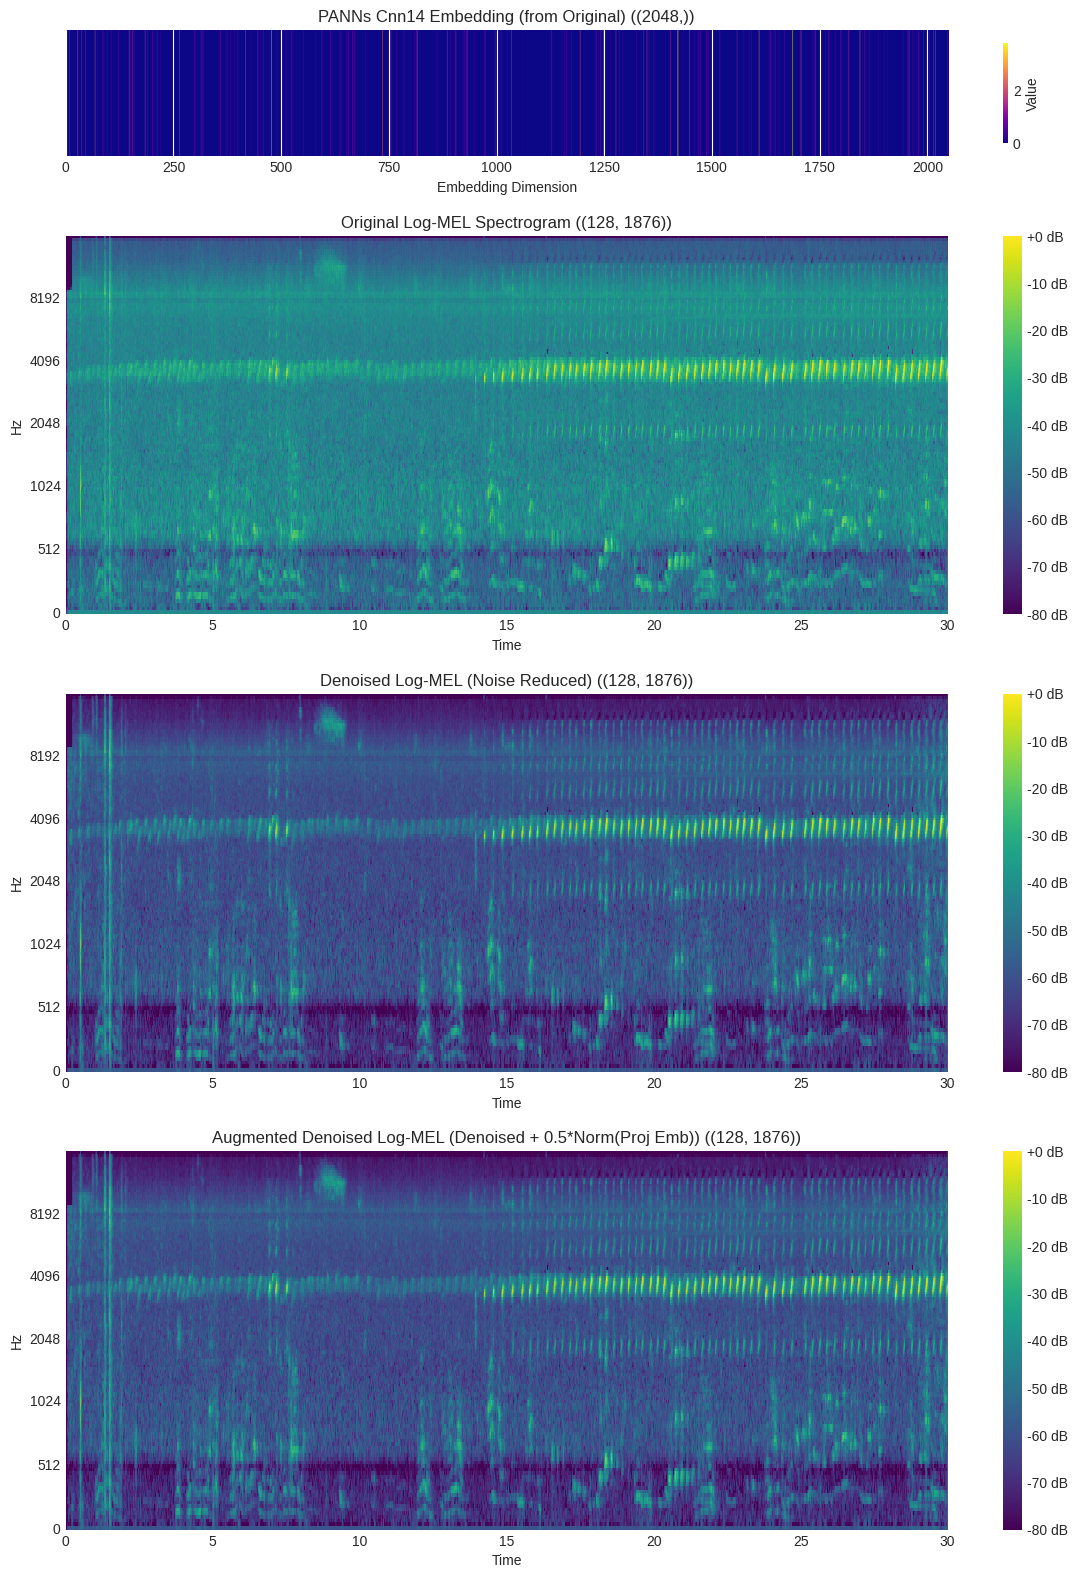

In [23]:
# 1. Setup Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# 2. Load PANNs Model
panns_model = None
try:
    print("Loading PANNs Cnn14 model...")
    panns_model = AudioTagging(checkpoint_path=None, device=device)
    panns_model.model.eval()
    print("PANNs Model loaded.")
except Exception as e:
    print(f"Fatal Error: Could not load PANNs model: {e}")
    panns_model = None

# Proceed only if PANNs model loaded and audio file exists
if panns_model and os.path.exists(audio_file_path):

    print(f"\n--- Processing Audio File: {audio_file_path} ---")
    # Initialize variables to None
    waveform_orig_np_32k = None
    log_mel_original_32k = None
    waveform_denoised_np_32k = None
    log_mel_denoised_32k = None
    panns_embedding = None
    augmented_denoised_mel = None

    try:
        # --- Load Original Audio (NumPy) ---
        waveform_orig_np, sr_orig = sf.read(audio_file_path, dtype='float32')
        if waveform_orig_np.ndim > 1: waveform_orig_np = waveform_orig_np.mean(axis=1) # Ensure mono
        print(f"Original audio loaded: Samples={len(waveform_orig_np)}, SR={sr_orig}Hz")

        # --- Truncate/Select Duration ---
        max_duration_sec = 30
        max_samples = int(max_duration_sec * sr_orig)
        actual_samples = len(waveform_orig_np)
        if actual_samples > max_samples:
            waveform_orig_np = waveform_orig_np[:max_samples]
            print(f"Truncated audio to first {max_duration_sec} seconds ({len(waveform_orig_np)} samples).")
        else:
            print(f"Using full audio duration ({actual_samples / sr_orig:.2f} seconds).")

        # --- Resample Original to Target SR (32kHz) ---
        print(f"\nResampling original audio to {PANNS_SR}Hz...")
        waveform_orig_np_32k = librosa.resample(waveform_orig_np, orig_sr=sr_orig, target_sr=PANNS_SR)
        print(f"Resampled original audio shape: {waveform_orig_np_32k.shape}")

        # --- Enhance Audio using Noise Reduction ---
        print(f"\nApplying noise reduction (prop_decrease={PROP_DECREASE}, stationary={STATIONARY_NOISE})...")
        # Perform noise reduction directly on the 32kHz signal
        # Note: This estimates noise from the signal itself. For better results,
        # if you have a known noise-only clip, use `nr.reduce_noise(y=..., sr=..., y_noise=...)`
        waveform_denoised_np_32k = nr.reduce_noise(
            y=waveform_orig_np_32k,
            sr=PANNS_SR,
            stationary=STATIONARY_NOISE,
            prop_decrease=PROP_DECREASE,
            # You might add chunk_size=60000 for memory efficiency on longer files
        )
        print(f"Noise reduction applied. Denoised audio shape: {waveform_denoised_np_32k.shape}")
        # Save denoised audio (optional but useful)
        sf.write(output_denoised_audio_path, waveform_denoised_np_32k, PANNS_SR)
        print(f"Noise-reduced audio saved to {output_denoised_audio_path}")


        # --- Extract PANNs Embedding (from Original 32k Audio) ---
        print("\nExtracting PANNs Embedding (from original)...")
        panns_embedding = get_panns_embedding(waveform_orig_np_32k, panns_model, device, PANNS_SR)


        # --- Calculate MEL Spectrograms (at 32kHz) ---
        print("\nCalculating MEL spectrograms...")
        log_mel_original_32k = calculate_mel_spectrogram(
            waveform_orig_np_32k, PANNS_SR, N_FFT, HOP_LENGTH, N_MELS
        )
        log_mel_denoised_32k = calculate_mel_spectrogram(
            waveform_denoised_np_32k, PANNS_SR, N_FFT, HOP_LENGTH, N_MELS
        )

        # --- Create Augmented Denoised Spectrogram ---
        print("\nCreating augmented spectrogram...")
        if log_mel_denoised_32k is not None and panns_embedding is not None:
            augmented_denoised_mel = create_augmented_mel(
                log_mel_denoised_32k, panns_embedding, N_MELS, alpha=ALPHA
            )
        else:
             print("Skipping augmentation due to missing denoised MEL or embedding.")


    except Exception as e:
        # Catch errors during the main loading/processing workflow
        print(f"An error occurred during the main processing workflow: {e}")
        import traceback
        traceback.print_exc()


    # --- Final Playback and Plotting ---
    print("\n--- Final Outputs ---")
    # Check if all necessary components for comparison exist before proceeding
    all_outputs_available_for_plot = (
        waveform_orig_np_32k is not None and
        log_mel_original_32k is not None and
        waveform_denoised_np_32k is not None and
        log_mel_denoised_32k is not None and
        panns_embedding is not None and
        augmented_denoised_mel is not None
    )
    all_outputs_available_for_audio = (
         waveform_orig_np_32k is not None and
         waveform_denoised_np_32k is not None and
         augmented_denoised_mel is not None # Need this for synthesis
    )


    if all_outputs_available_for_audio:
        print("\n--- Audio Playback ---")
        # 1. Original Audio (32kHz)
        print("\n1. Original Audio (Resampled to 32kHz):")
        ipd.display(ipd.Audio(waveform_orig_np_32k, rate=PANNS_SR))
        # 2. Denoised Audio (Noise Reduced, 32kHz)
        print("\n2. Denoised Audio (Noise Reduced, 32kHz):")
        ipd.display(ipd.Audio(waveform_denoised_np_32k, rate=PANNS_SR)) # Play the denoised audio
        # 3. Synthesized Audio from Augmented Denoised MEL
        print("\n3. Synthesized Audio from Augmented Denoised MEL:")
        audio_player_aug_denoised = play_mel_spectrogram(
            augmented_denoised_mel, PANNS_SR, N_FFT, HOP_LENGTH, label="Augmented Denoised MEL"
        )
        if audio_player_aug_denoised:
            ipd.display(audio_player_aug_denoised)
        else:
            print("Could not synthesize audio for Augmented Denoised MEL.")

    else:
        print("Skipping audio playback as not all required audio signals were generated.")


    if all_outputs_available_for_plot:
        # --- Plotting ---
        print("\n--- Plots ---")
        plt.style.use('seaborn-v0_8-darkgrid')
        # Create 4 rows of plots
        fig, axes = plt.subplots(4, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [1, 3, 3, 3]}) # Adjust ratios

        # Plot 1: PANNs Embedding
        ax = axes[0]; img_emb = ax.imshow(panns_embedding[np.newaxis, :], aspect='auto', cmap='plasma');
        ax.set_title(f'PANNs Cnn14 Embedding (from Original) ({panns_embedding.shape})'); ax.set_xlabel('Embedding Dimension'); ax.set_yticks([]); fig.colorbar(img_emb, ax=ax, label='Value', shrink=0.8)

        # Plot 2: Original Log-MEL
        ax = axes[1]; img_orig = librosa.display.specshow(log_mel_original_32k, sr=PANNS_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax, cmap='viridis');
        ax.set_title(f'Original Log-MEL Spectrogram ({log_mel_original_32k.shape})'); fig.colorbar(img_orig, ax=ax, format='%+2.0f dB')

        # Plot 3: Denoised Log-MEL (Noise Reduced)
        ax = axes[2]; img_denoised = librosa.display.specshow(log_mel_denoised_32k, sr=PANNS_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax, cmap='viridis');
        ax.set_title(f'Denoised Log-MEL (Noise Reduced) ({log_mel_denoised_32k.shape})'); fig.colorbar(img_denoised, ax=ax, format='%+2.0f dB')

        # Plot 4: Augmented Denoised Log-MEL
        ax = axes[3]; img_ad_mel = librosa.display.specshow(augmented_denoised_mel, sr=PANNS_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax, cmap='viridis');
        ax.set_title(f'Augmented Denoised Log-MEL (Denoised + {ALPHA}*Norm(Proj Emb)) ({augmented_denoised_mel.shape})'); fig.colorbar(img_ad_mel, ax=ax, format='%+2.0f dB')

        plt.tight_layout(pad=1.5); plt.show()

    else:
        print("\nCould not generate all outputs for plotting. Check logs for errors.")
        # Add status check if needed


# Final else block for handling initial model loading failures
else:
    print("\nProcessing aborted. Check PANNs model loading step or audio file path.")
    if not panns_model: print("- PANNs model not loaded.")
    if not os.path.exists(audio_file_path): print(f"- Audio file not found: {audio_file_path}")
